In [1]:
from sklearn.datasets import make_circles
import torch


#1000 samples
n_samples = 1000

#create circle
x, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 samples of X : \n {x[:5]}")
print(f"First 5 samples of Y : \n {y[:5]}")

First 5 samples of X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of Y : 
 [1 1 1 1 0]


In [2]:
#Make dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": x[:, 0],
                        "X2": x[:, 1],
                        "labels": y})
circles.head(10)

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


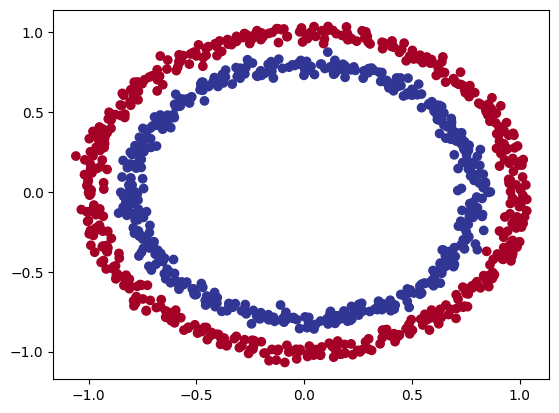

In [3]:
#visualize
import matplotlib.pyplot as plt

plt.scatter(x=x[:, 0], y=x[:, 1], c=y, cmap=plt.cm.RdYlBu)


Check input output shapes

In [4]:
x.shape, y.shape

((1000, 2), (1000,))

In [5]:
#View feature and labels
x_sample = x[0]
y_sample = y[0]

#data into tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [6]:
torch.manual_seed(42)
#split into training and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
#building model
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CircleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))  #x->layer1->layer2->output


model1 = CircleModelv0().to(device)
model1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer2.bias', tensor([-0.2060], device='cuda:0'))])

In [8]:
next(model1.parameters())
model1.state_dict()


OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer2.bias', tensor([-0.2060], device='cuda:0'))])

In [9]:
#using sequential

model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [10]:
with torch.inference_mode():
    untrained_pred = model1(x_test.to(device))
print(f"Length of prediction: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test sample: {len(x_test)}, Shape: {x_test.shape}")
print(f"\nFirst 10 prediction: {untrained_pred[:10]}")
print(f"\nFirst 10 label: {y_test[:10]}")

Length of prediction: 200, Shape: torch.Size([200, 1])
Length of test sample: 200, Shape: torch.Size([200, 2])

First 10 prediction: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 label: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [11]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [12]:
#calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [13]:
#Train Model
#raw logits -> prediction probabilities -> predictiom labels

model1.eval()
with torch.inference_mode():
    y_logits = model1(x_test.to(device))[:5]
print(y_logits)

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')


In [14]:
#logits turn into prediction probabilities

y_pred_probs=torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')


In [15]:
#find prediction labels
y_pred = torch.round(y_pred_probs)
y_pred_label = torch.round(torch.sigmoid(model1(x_test.to(device))[:5]))
print(torch.eq(y_pred.squeeze(), y_pred_label.squeeze()))
y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [16]:
torch.cuda.manual_seed(42)
epochs = 100
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model1.train()

    y_logits = model1(x_train.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #    loss = loss_fn(torch.sigmoid(y_logits), y_pred)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model1.eval()
    with torch.inference_mode():
        test_logits = model1(x_test.to(device)).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Accuracy: {acc:.2f}, Test accuracy: {test_acc:.2f}")

Epoch: 0, Loss: 0.69796, Accuracy: 51.88, Test accuracy: 58.00
Epoch: 10, Loss: 0.69590, Accuracy: 51.25, Test accuracy: 53.00
Epoch: 20, Loss: 0.69490, Accuracy: 51.62, Test accuracy: 49.50
Epoch: 30, Loss: 0.69435, Accuracy: 51.12, Test accuracy: 49.50
Epoch: 40, Loss: 0.69401, Accuracy: 50.88, Test accuracy: 51.00
Epoch: 50, Loss: 0.69378, Accuracy: 50.25, Test accuracy: 50.00
Epoch: 60, Loss: 0.69362, Accuracy: 50.00, Test accuracy: 51.50
Epoch: 70, Loss: 0.69351, Accuracy: 50.25, Test accuracy: 51.00
Epoch: 80, Loss: 0.69342, Accuracy: 49.88, Test accuracy: 50.00
Epoch: 90, Loss: 0.69336, Accuracy: 49.88, Test accuracy: 53.00


In [17]:
#prediction vialise
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download


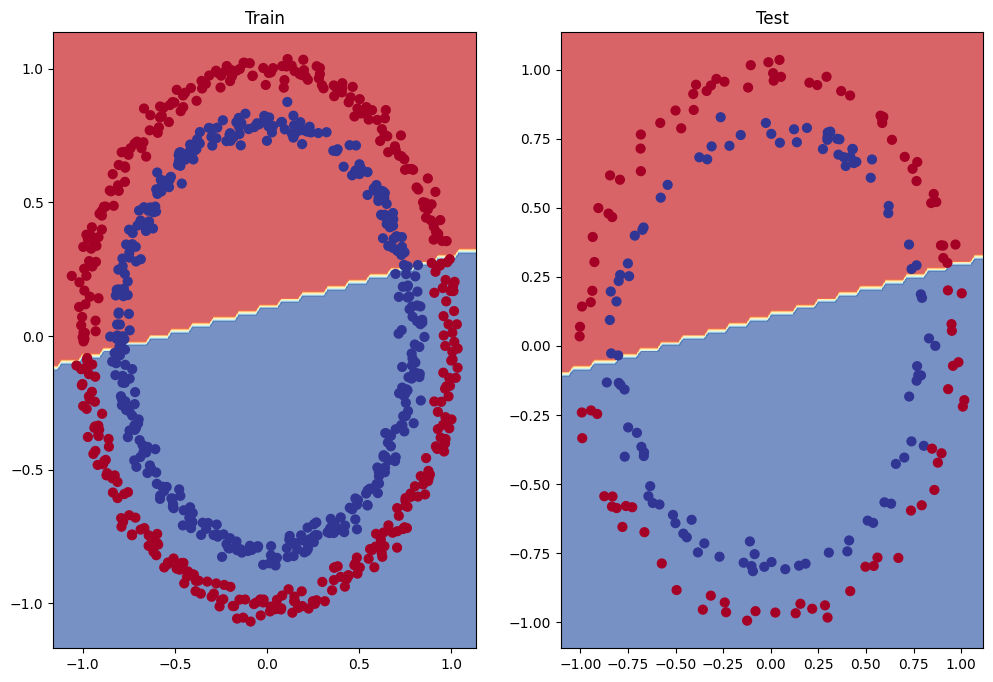

In [18]:
from helper_functions import plot_predictions, plot_decision_boundary

#plot descsion boudnary of a model
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model1, x_test, y_test)

Imporving


In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1